## Context Ad Clicks Dataset

### About Dataset

#### Context

The dataset generated by an E-commerce website which sells a variety of products at its online platform. The records user behaviour of its customers and stores it as a log. However, most of the times, users do not buy the products instantly and there is a time gap during which the customer might surf the internet and maybe visit competitor websites. Now, to improve sales of products, website owner has hired an Adtech company which built a system such that ads are being shown for owner products on its partner websites. If a user comes to owner website and searches for a product, and then visits these partner websites or apps, his/her previously viewed items or their similar items are shown on as an ad. If the user clicks this ad, he/she will be redirected to the owner website and might buy the product.

The task is to predict the probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

#### Content
You are provided with the view log of users (2018/10/15 - 2018/12/11) and the product description collected from the owner website. We also provide the training data and test data containing details for ad impressions at the partner websites(Train + Test). Train data contains the impression logs during 2018/11/15 – 2018/12/13 along with the label which specifies whether the ad is clicked or not. Your model will be evaluated on the test data which have impression logs during 2018/12/12 – 2018/12/18 without the labels. You are provided with the following files:

train.zip: This contains 3 files and description of each is given below:

- train.csv
- view_log.csv
- item_data.csv
- test.csv: test file contains the impressions for which the participants need to predict the click rate sample_submission.csv: This file contains the format in which you have to submit your predictions.

#### Inspiration
Predict the probability probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.
The evaluated metric could be "area under the ROC curve" between the predicted probability and the observed target.

In [1]:
import pandas as pd

In [2]:
import warnings ## importing warnings library 
warnings.filterwarnings('ignore') ## Ignore warning

### Collecting data

In [3]:
train = pd.read_csv('task_1_dataset/train_adc/train.csv')
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [4]:
train.shape

(237609, 7)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   impression_id    237609 non-null  object
 1   impression_time  237609 non-null  object
 2   user_id          237609 non-null  int64 
 3   app_code         237609 non-null  int64 
 4   os_version       237609 non-null  object
 5   is_4G            237609 non-null  int64 
 6   is_click         237609 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [6]:
train['impression_time'] = pd.to_datetime(train['impression_time'])

In [7]:
df_train = train.merge(train, how='left', on='user_id', suffixes=('', '_before'))
df_train['Date_Diff'] = (df_train['impression_time'] - df_train['impression_time_before']).dt.days
df_train = df_train.drop(df_train[df_train['impression_time'] <= df_train['impression_time_before']].index)
df_train = df_train.drop(df_train[df_train['Date_Diff'] < -7].index)

In [8]:
df_impressions_before=df_train.groupby('impression_id')['impression_id_before'].count().reset_index()
df_impressions_before = df_impressions_before.rename(columns={"impression_id_before": "impressions_before_count"}) 

In [9]:
df_train_plus = train.merge(df_impressions_before, how='left', on='impression_id')
df_train_plus['impressions_before_count'].fillna(0, inplace=True)
df_train_plus['impressions_before_count'] = df_train_plus['impressions_before_count'].astype('int')
df_train_plus.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0


In [10]:
df_train_plus.shape

(237609, 8)

In [11]:
view_log = pd.read_csv('task_1_dataset/train_adc/view_log.csv')
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [12]:
view_log.shape

(3118622, 5)

In [13]:
view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   server_time  object
 1   device_type  object
 2   session_id   int64 
 3   user_id      int64 
 4   item_id      int64 
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


In [14]:
view_log['server_time'] = pd.to_datetime(view_log['server_time'])

In [15]:
view_log_1=view_log.groupby(['user_id','server_time'])['item_id'].median().reset_index()
view_log_1['item_id'] = view_log_1['item_id'].astype('int')

In [16]:
view_log_2=view_log.groupby(['user_id','server_time'])['device_type'].last().reset_index()

In [17]:
view_log_3 = view_log_1.merge(view_log_2, how='inner', on=['user_id','server_time'])

In [18]:
df_train_inner_join_log = df_train_plus.merge(view_log_3, how='left', on='user_id')


In [19]:
df_train_inner_join_log.shape

(9619563, 11)

In [20]:
cols_with_missing = [col for col in df_train_inner_join_log.columns
                     if df_train_inner_join_log[col].isnull().any()]
cols_with_missing

[]

In [21]:
df_train_inner_join_log = df_train_inner_join_log.drop(df_train_inner_join_log[df_train_inner_join_log['impression_time'] <= df_train_inner_join_log['server_time']].index)
df_train_inner_join_log['Date_Diff'] = (df_train_inner_join_log['impression_time'] - df_train_inner_join_log['server_time']).dt.days
df_train_inner_join_log = df_train_inner_join_log.drop(df_train_inner_join_log[df_train_inner_join_log['Date_Diff'] > 7].index)

In [22]:
df_train_inner_join_log.sort_values(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count','server_time'])
df_train_inner_join_log_1=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['server_time'].count().reset_index()
df_train_inner_join_log_2=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['item_id'].last().reset_index()
df_train_inner_join_log_3=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['device_type'].last().reset_index()

In [23]:
df_train_inner_join_log_4 = df_train_inner_join_log_1.merge(df_train_inner_join_log_2, how='inner', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])
df_train_inner_join_log_all = df_train_inner_join_log_4.merge(df_train_inner_join_log_3, how='inner', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])

In [24]:
df_train_inner_join_log_all.shape

(185488, 10)

In [25]:
df_train_inner_join_log_all.head()

,impression_id,impression_time,user_id,app_code,is_4G,is_click,impressions_before_count,server_time,item_id,device_type
0,00003e3b9e5336685200ae85d21b4f5e,2018-11-15 12:26:00,38051,207,1,0,0,5,2121,android
1,00005d011db80a956aab176cc94d1d37,2018-12-12 15:56:00,4842,207,0,0,9,2,425,android
2,0000b2815cc3c2b56867cbbf4d36efa5,2018-12-06 10:51:00,16990,214,0,0,0,1,30469,android
3,0001261e2060303a06ba6c64d676d639,2018-11-29 00:53:00,8726,3,0,0,20,21,76982,android
4,000133296ef6b63b0210f224e1347365,2018-12-05 15:25:00,928,190,0,0,16,124,44826,android


In [26]:
item_data = pd.read_csv('task_1_dataset/train_adc/item_data.csv')
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [27]:
df_train_inner_join_log_item = df_train_inner_join_log_all.merge(item_data, how='left', on='item_id')

In [28]:
df_train_inner_join_log_item = df_train_inner_join_log_item.rename({'server_time': 'log_client_web_site_count', 
                                                                  'item_id': 'log_client_web_site_item_id', 
                                                                  'device_type': 'log_client_web_site_device_type',
                                                                  'category_1': 'item_category_1',
                                                                  'category_2': 'item_category_2',
                                                                  'category_3': 'item_category_3',
                                                                  'product_type':'item_product_type'
                                                                  }, axis=1)


In [29]:
df_train_inner_join_log_item.head()

,impression_id,impression_time,user_id,app_code,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,00003e3b9e5336685200ae85d21b4f5e,2018-11-15 12:26:00,38051,207,1,0,0,5,2121,android,249.0,0.0,45.0,117.0,6379.0
1,00005d011db80a956aab176cc94d1d37,2018-12-12 15:56:00,4842,207,0,0,9,2,425,android,1025.0,4.0,74.0,292.0,4524.0
2,0000b2815cc3c2b56867cbbf4d36efa5,2018-12-06 10:51:00,16990,214,0,0,0,1,30469,android,1843.0,13.0,58.0,273.0,420.0
3,0001261e2060303a06ba6c64d676d639,2018-11-29 00:53:00,8726,3,0,0,20,21,76982,android,28736.0,1.0,42.0,157.0,8817.0
4,000133296ef6b63b0210f224e1347365,2018-12-05 15:25:00,928,190,0,0,16,124,44826,android,2073.0,13.0,78.0,287.0,5568.0


In [30]:
df_train_inner_join_log_item.shape

(185488, 15)

In [31]:
df_train_plus_log_item = df_train_plus.merge(df_train_inner_join_log_item, how='left', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])


In [32]:
df_train_plus_log_item.shape

(237609, 16)

In [33]:
df_train_plus_log_item.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,9.0,2715.0,android,1601.0,14.0,61.0,159.0,7093.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,7.0,4069.0,android,4556.0,7.0,24.0,100.0,9215.0


In [34]:
df_train_plus_log_item['log_client_web_site_count'].fillna(0, inplace=True)
df_train_plus_log_item['log_client_web_site_item_id'].fillna(0, inplace=True)
df_train_plus_log_item['log_client_web_site_device_type'].fillna('no', inplace=True)
df_train_plus_log_item['item_price'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_1'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_2'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_3'].fillna(0, inplace=True)
df_train_plus_log_item['item_product_type'].fillna(0, inplace=True)

In [35]:
df_train_plus_log_item['log_client_web_site_count'] = df_train_plus_log_item['log_client_web_site_count'].astype('int')
df_train_plus_log_item['log_client_web_site_item_id'] = df_train_plus_log_item['log_client_web_site_item_id'].astype('int')
df_train_plus_log_item['item_category_1'] = df_train_plus_log_item['item_category_1'].astype('int')
df_train_plus_log_item['item_category_2'] = df_train_plus_log_item['item_category_2'].astype('int')
df_train_plus_log_item['item_category_3'] = df_train_plus_log_item['item_category_3'].astype('int')
df_train_plus_log_item['item_product_type'] = df_train_plus_log_item['item_product_type'].astype('int')

### EDA and Feature Engineering

In [36]:
master_data=df_train_plus_log_item
master_data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,0,0,no,0.0,0,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,0,0,no,0.0,0,0,0,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,0,0,no,0.0,0,0,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,9,2715,android,1601.0,14,61,159,7093
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,7,4069,android,4556.0,7,24,100,9215


In [37]:
master_data.tail()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
237604,880e88bf5c86c1b11a2ac7072ebfb932,2018-12-13 07:40:00,17758,207,latest,1,0,2,6,95491,android,6400.0,14,61,132,9842
237605,3e6bd8cace08e2102dffef3c86d7d793,2018-12-13 07:41:00,26845,207,latest,0,0,2,1,127045,android,21696.0,1,7,308,4986
237606,8e58582b20ebfacb84fc338bac7cd5ae,2018-12-13 07:42:00,69412,289,old,0,0,5,0,0,no,0.0,0,0,0,0
237607,9ccc5e0a6dc7a2f5224890a22defbd00,2018-12-13 07:43:00,19918,385,old,0,1,14,15,4337,android,1280.0,1,12,301,3805
237608,a68c052cab131719dede538b5466428e,2018-12-13 07:43:00,9647,336,old,1,0,3,5,77251,android,12192.0,9,3,159,176


In [38]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   impression_id                    237609 non-null  object        
 1   impression_time                  237609 non-null  datetime64[ns]
 2   user_id                          237609 non-null  int64         
 3   app_code                         237609 non-null  int64         
 4   os_version                       237609 non-null  object        
 5   is_4G                            237609 non-null  int64         
 6   is_click                         237609 non-null  int64         
 7   impressions_before_count         237609 non-null  int64         
 8   log_client_web_site_count        237609 non-null  int64         
 9   log_client_web_site_item_id      237609 non-null  int64         
 10  log_client_web_site_device_type  237609 non-

In [39]:
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization

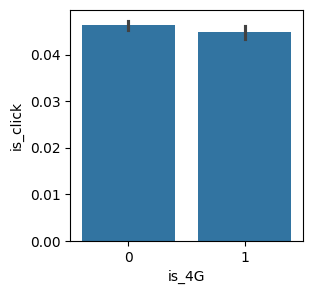

In [40]:
# Exploration of is_4G feature
plt.figure(figsize=(3,3))
sns.barplot(master_data, x='is_4G', y='is_click')
plt.show()

Использование технологии 4G немного уменьшает вероятность реакции на рекламу

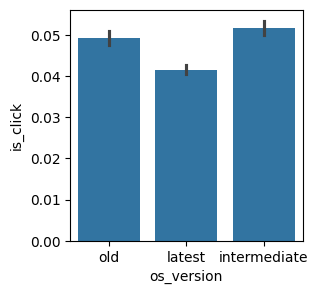

In [41]:
# Exploration of os_version feature
plt.figure(figsize=(3,3))
sns.barplot(master_data, x='os_version', y='is_click')
plt.show()

Обладатели ПО новейших версий хуже реагируют на рекламу

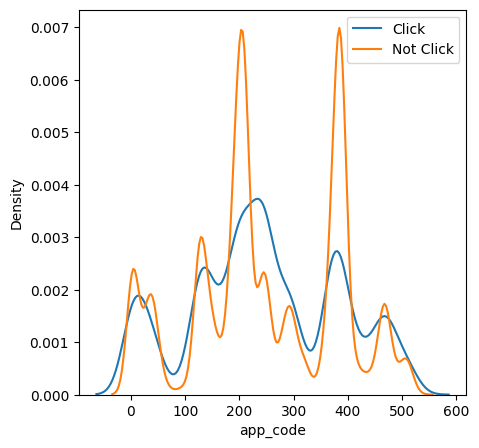

In [42]:
# Exploration of app_code feature
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["app_code"][master_data["is_click"] == 1])
sns.kdeplot(master_data["app_code"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

Есть приложения, в котором реклама работает более эффективно, а есть в которых менее эффективно

In [43]:
# Create features for weekday, month, day, hour, and minute
master_data['impression_day_of_week'] = master_data['impression_time'].dt.day_of_week
master_data['impression_hour_of_day'] = master_data['impression_time'].dt.hour


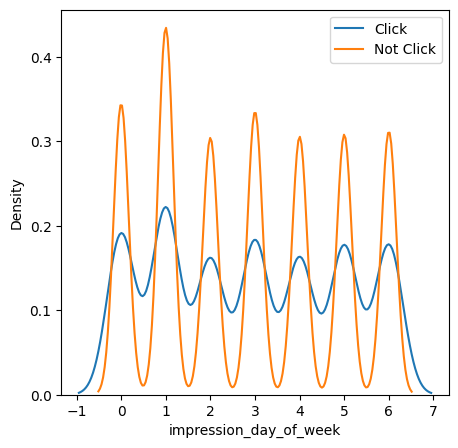

In [44]:
# Exploration of impression_day_of_week feature
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["impression_day_of_week"][master_data["is_click"] == 1])
sns.kdeplot(master_data["impression_day_of_week"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

Есть небольшие закономерности по дням недели

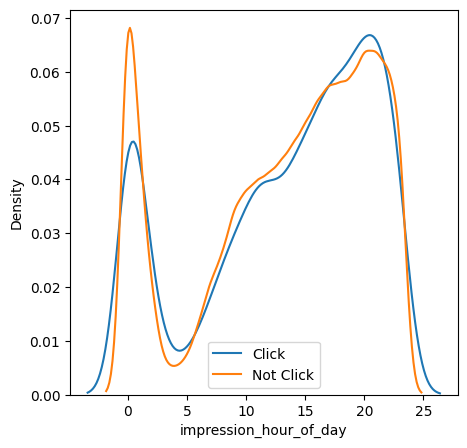

In [45]:
# Exploration of impression_hour_of_day feature
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["impression_hour_of_day"][master_data["is_click"] == 1])
sns.kdeplot(master_data["impression_hour_of_day"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

Есть закономерность по времени дня

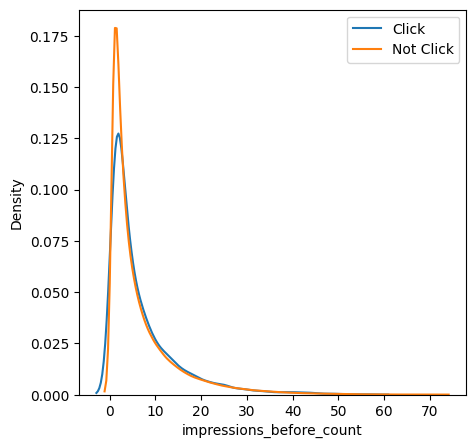

In [46]:
# Exploration of impressions_before_count feature
master_data1=master_data[master_data["impressions_before_count"] != 0]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data1["impressions_before_count"][master_data1["is_click"] == 1])
sns.kdeplot(master_data1["impressions_before_count"][master_data1["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

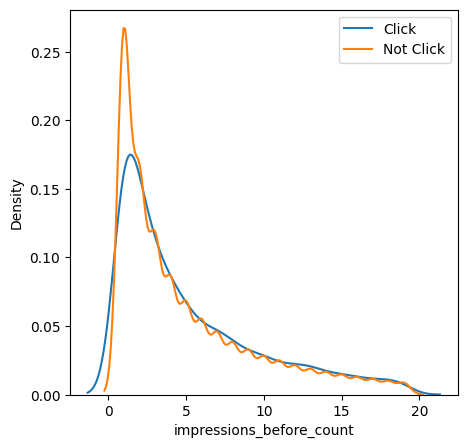

In [47]:
# Exploration of impressions_before_count feature
master_data2=master_data1[master_data1["impressions_before_count"] < 20]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data2["impressions_before_count"][master_data2["is_click"] == 1])
sns.kdeplot(master_data2["impressions_before_count"][master_data2["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

Зависимость от того, как часто показывалась реклама до текущего показа

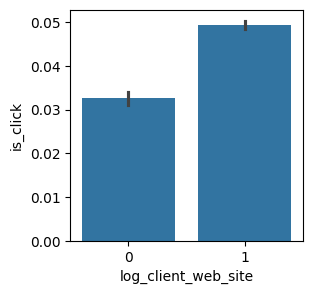

In [48]:
# Exploration of log_client_web_site_count feature
import numpy as np
master_data['log_client_web_site'] = np.where(master_data['log_client_web_site_count']!=0, 1, 0)


plt.figure(figsize=(3,3))
sns.barplot(master_data, x='log_client_web_site', y='is_click')
plt.show()

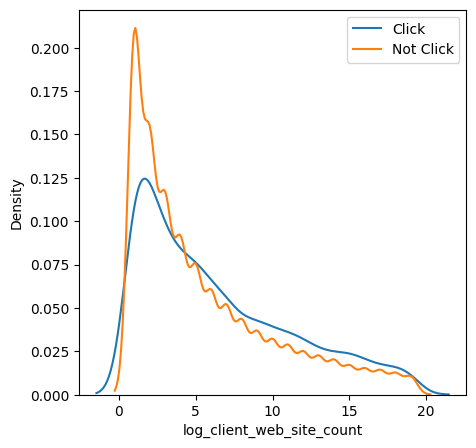

In [49]:
# Exploration of log_client_web_site_count feature
master_data1=master_data[master_data["log_client_web_site_count"] != 0]
master_data2=master_data1[master_data1["log_client_web_site_count"] < 20]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data2["log_client_web_site_count"][master_data2["is_click"] == 1])
sns.kdeplot(master_data2["log_client_web_site_count"][master_data2["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

Зависимость эффективности рекламы от того заходил ли пользователь на сайт клиента и сколько раз

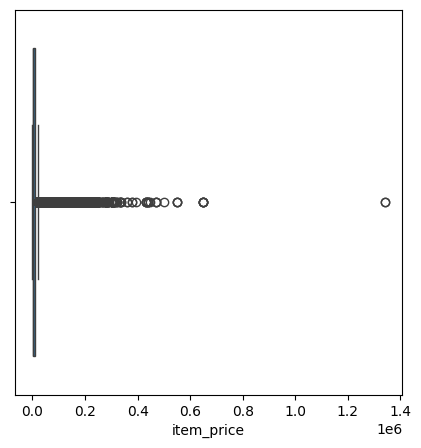

In [50]:
# Exploration of item_price feature
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_price')
plt.show()

Очень грязный признак

In [51]:
# find outliers

Upper_boundary = master_data1.item_price.mean() + 3* master_data1.item_price.std()
Lower_boundary = master_data1.item_price.mean() - 3* master_data1.item_price.std()
print('item_price outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))


item_price outliers are values < -70829.62445846855 or > 94443.24142560389


In [52]:
master_data1.item_price.describe()

count    1.854880e+05
mean     1.180681e+04
std      2.754548e+04
min      0.000000e+00
25%      1.459000e+03
50%      2.822000e+03
75%      8.960000e+03
max      1.340800e+06
Name: item_price, dtype: float64

In [53]:
# top-coding the item_price variable
master_data1.loc[master_data1.item_price>94443, 'item_price'] = 94443
master_data1.item_price.max()

94443.0

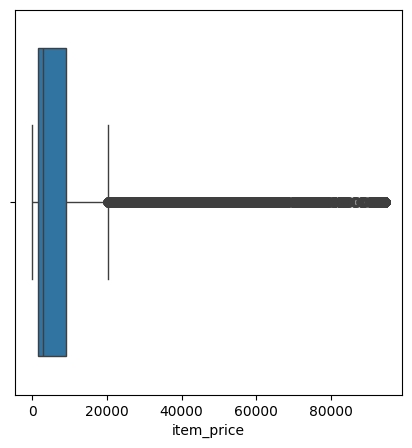

In [54]:
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_price')
plt.show()

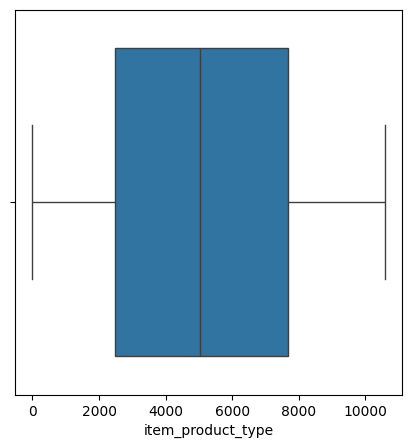

In [55]:
# Exploration of item_product_type feature
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_product_type')
plt.show()

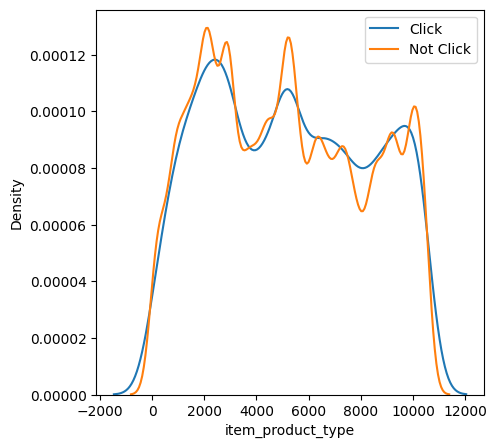

In [56]:
# Exploration of item_product_type feature
plt.figure(figsize=(5,5))
sns.kdeplot(master_data1["item_product_type"][master_data1["is_click"] == 1])
sns.kdeplot(master_data1["item_product_type"][master_data1["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

<Axes: xlabel='item_category_3'>

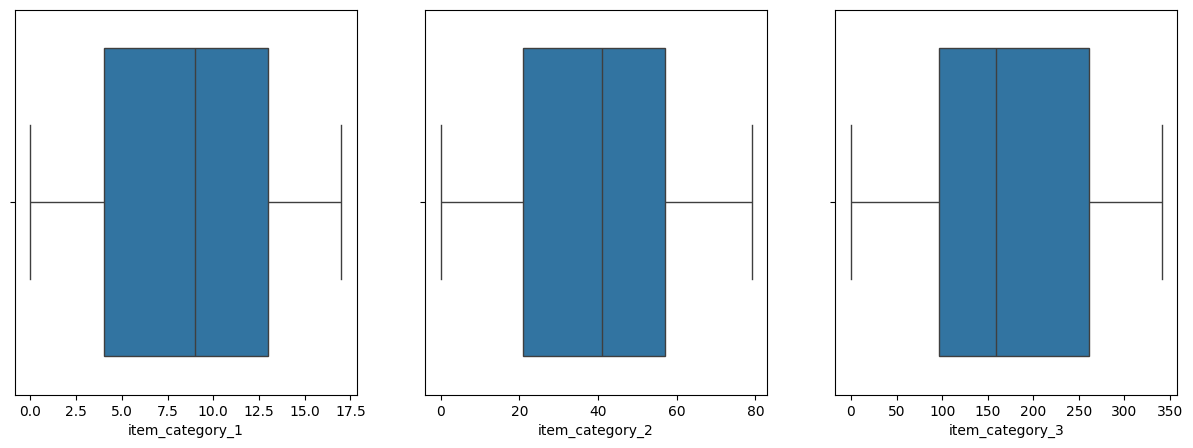

In [57]:
# Exploration of item_category feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# item_category_1
sns.boxplot(ax=axes[0], x=master_data1["item_category_1"])

# item_category_1
sns.boxplot(ax=axes[1], x=master_data1["item_category_2"])

# item_category_1
sns.boxplot(ax=axes[2], x=master_data1["item_category_3"])

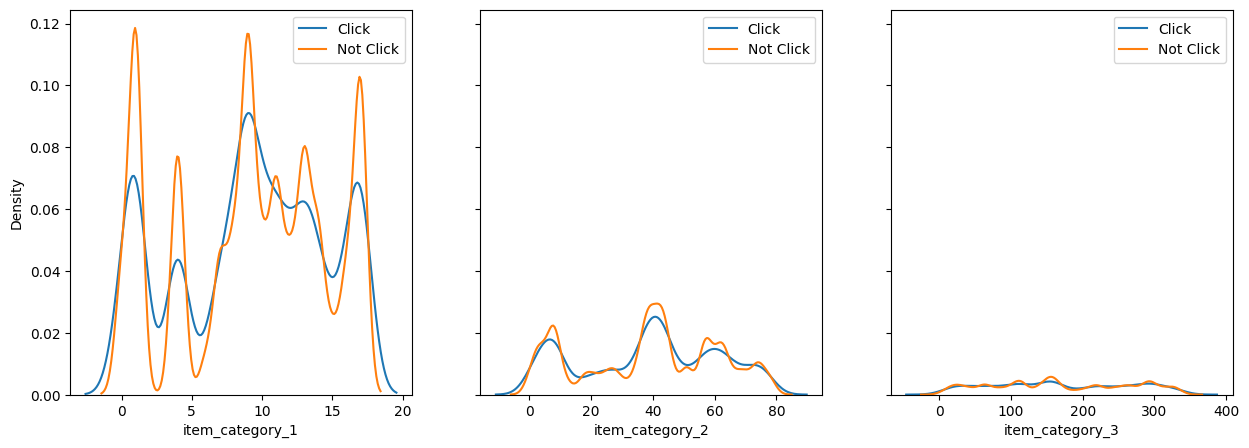

In [58]:
# Exploration of item_category feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True);

# item_category_1
sns.kdeplot(ax=axes[0], x=master_data1["item_category_1"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[0], x=master_data1["item_category_1"][master_data1["is_click"] == 0]);
axes[0].legend(['Click', 'Not Click']);

# item_category_2
sns.kdeplot(ax=axes[1], x=master_data1["item_category_2"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[1], x=master_data1["item_category_2"][master_data1["is_click"] == 0]);
axes[1].legend(['Click', 'Not Click']);

# item_category_2
sns.kdeplot(ax=axes[2], x=master_data1["item_category_3"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[2], x=master_data1["item_category_3"][master_data1["is_click"] == 0]);
axes[2].legend(['Click', 'Not Click']);


In [59]:
# Choose informative columns
columns = ['impression_day_of_week','impression_hour_of_day','app_code', 'os_version', 'is_4G','impressions_before_count','log_client_web_site_count','log_client_web_site_device_type','item_price','item_product_type','item_category_1','item_category_2','item_category_3','is_click']
master_data_result= master_data[columns].copy()

In [60]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [61]:
# Categorical encoding
categorical_columns = ['os_version','log_client_web_site_device_type']

encoder = OrdinalEncoder()
master_data_result[categorical_columns]=encoder.fit_transform(master_data_result[categorical_columns])


In [62]:
master_data_result['os_version'] = master_data_result['os_version'].astype('int')
master_data_result['log_client_web_site_device_type'] = master_data_result['log_client_web_site_device_type'].astype('int')

In [63]:
# Feature Scaling
columns_for_scaling = ['app_code','log_client_web_site_count','item_price','item_product_type','item_category_3']

scaler = StandardScaler()
master_data_result[columns_for_scaling] = scaler.fit_transform(master_data_result[columns_for_scaling])


In [64]:
master_data_result.head()

,impression_day_of_week,impression_hour_of_day,app_code,os_version,is_4G,impressions_before_count,log_client_web_site_count,log_client_web_site_device_type,item_price,item_product_type,item_category_1,item_category_2,item_category_3,is_click
0,3,0,1.278720,2,0,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,0
1,3,0,1.611528,1,1,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,1
2,3,0,0.073218,0,1,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,0
3,3,0,-0.037718,1,1,0,0.176800,0,-0.306808,0.896750,14,61,0.237936,0
4,3,0,1.655902,1,0,0,0.003378,0,-0.187765,1.517678,7,24,-0.299669,0


In [65]:
# analysis of correlation
columns = ['impressions_before_count','log_client_web_site_count','item_price']
corr = master_data_result[columns].corr()
corr

,impressions_before_count,log_client_web_site_count,item_price
impressions_before_count,1.000000,0.120661,0.015932
log_client_web_site_count,0.120661,1.000000,0.049325
item_price,0.015932,0.049325,1.000000


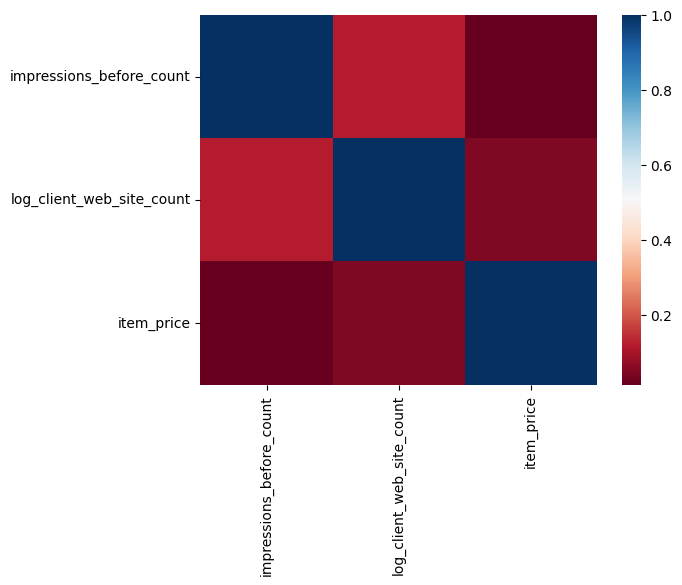

In [66]:
sns.heatmap(corr, cmap="RdBu")
plt.show()

### Machine Learning

In [67]:
# Specify Prediction Target and data for ML
y = master_data_result.is_click
X = master_data_result.drop('is_click', axis=1)

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Train/Test split results:
Accuracy is 0.956
Logarithmic loss is 0.180
The Area Under the ROC (AUC) curve is 0.571


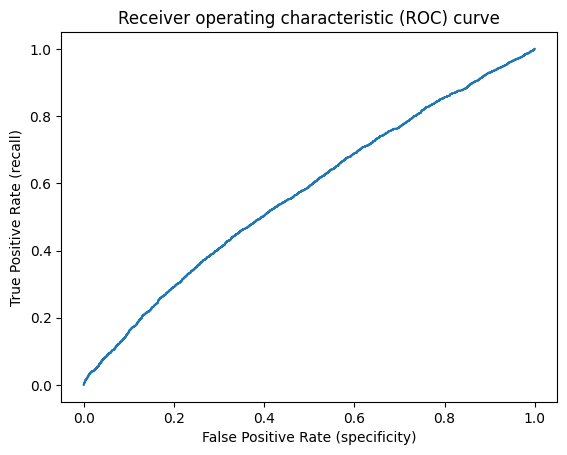

In [70]:
# Model evaluation based on simple train/test split using train_test_split() function

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(y_test, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

In [71]:
# Model evaluation based on K-fold cross-validation using cross_val_score() function

logreg = LogisticRegression()
scores_accuracy = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_train, y_train, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_train, y_train, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print("Average Accuracy is %2.3f" % scores_accuracy.mean())
print("Average Logarithmic Loss is %2.3f" % -scores_log_loss.mean())
print("The Average Area Under the ROC (AUC) Curve is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
Average Accuracy is 0.954
Average Logarithmic Loss is 0.185
The Average Area Under the ROC (AUC) Curve is 0.572


In [72]:
# Model hyperparameter tuning with GridSearchCV

parameters = {"C": [0.001, 0.01, 0.1, 1.], "penalty": ["l1", "l2"]}
logreg = LogisticRegression()

model_logreg = GridSearchCV(logreg, parameters, cv=10, scoring='roc_auc')
model_logreg.fit(X_train, y_train)

print('Hyperparameter tuning with GridSearchCV')
print(f'Best parameters {model_logreg.best_params_}')

print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logreg.best_score_:.3f}'
)

Hyperparameter tuning with GridSearchCV
Best parameters {'C': 0.001, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.573


Model have high accuracy but a low ROC-AUC score. Скорее всего из-за несбалансированности набора данных

### Decision Trees

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [74]:
# Split Data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

In [75]:

# Specify the model. 
# For model reproducibility, set a numeric value for random_state when specifying the model
model_tree = DecisionTreeClassifier(random_state=1)

# Fit the model with the training data.
model_tree.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

Train/Test split results:
Accuracy is 0.913
Logarithmic loss is 3.149
The Area Under the ROC (AUC) curve is 0.522


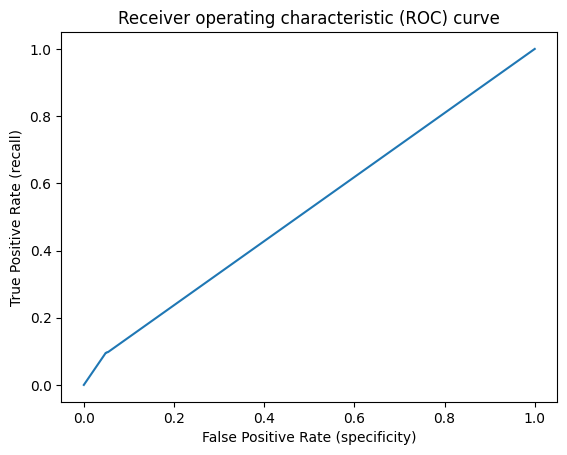

In [76]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = model_tree.predict(val_X)
y_pred_proba = model_tree.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

In [77]:
def get_auc(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)
    y_pred_proba = model.predict_proba(val_X)[:, 1]
    [fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)
    return(auc(fpr, tpr))

In [78]:
# Compare Different Tree Sizes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_auc = get_auc(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t The Area Under the ROC (AUC) curve is %2.3f" %(max_leaf_nodes, my_auc))

Max leaf nodes: 5  		 The Area Under the ROC (AUC) curve is 0.615
Max leaf nodes: 25  		 The Area Under the ROC (AUC) curve is 0.683
Max leaf nodes: 50  		 The Area Under the ROC (AUC) curve is 0.690
Max leaf nodes: 100  		 The Area Under the ROC (AUC) curve is 0.689
Max leaf nodes: 250  		 The Area Under the ROC (AUC) curve is 0.690
Max leaf nodes: 500  		 The Area Under the ROC (AUC) curve is 0.683


### Random Forest

In [79]:
# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit your model
rf_model.fit(train_X, train_y)

RandomForestClassifier(random_state=1)

Train/Test split results:
Accuracy is 0.950
Logarithmic loss is 0.300
The Area Under the ROC (AUC) curve is 0.658


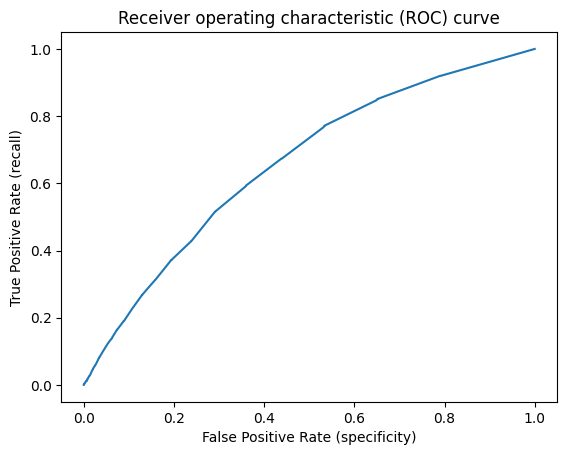

In [80]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = rf_model.predict(val_X)
y_pred_proba = rf_model.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

### XGBoost

In [81]:
from xgboost import XGBClassifier

In [82]:

# Define the model
model_XGB = XGBClassifier(random_state=0)

# Fit the model
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Accuracy is 0.955
Logarithmic loss is 0.156
The Area Under the ROC (AUC) curve is 0.803


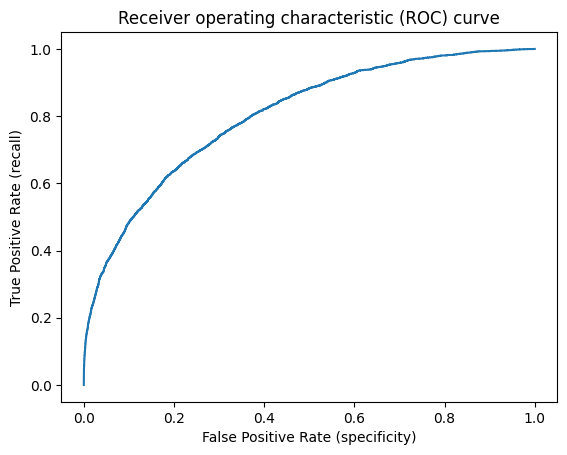

In [83]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = model_XGB.predict(val_X)
y_pred_proba = model_XGB.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()